# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

#### Scenario 2: Market research for new store locations

A liquor store owner in Iowa is looking to expand to new locations and has hired you to investigate the market data for potential new locations. The business owner is interested in the details of the best model you can fit to the data so that his team can evaluate potential locations for a new storefront.

**Goal for Scenario #2:** Your task is to:

* Build models of total sales based on location, price per bottle, total bottles sold. You may find it useful to build models for each county, zip code, or city.
* Provide a table of the best performing stores by location type of your choice (city, county, or zip code) and the predictions of your model(s).
* Based on your models and the table of data, recommend some general locations to the business owner, taking into account model performance. Validate your model's performance and ability to predict future sales using cross-validation.
* _Bonus_: Recommend targets for volume sold and price per bottle!

---

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import pprint

In [2]:
## Load the data into a DataFrame
df = pd.read_csv("Iowa_Liquor_sales_sample_10pct.csv")

## Transform the dates if needed, e.g.
# df["Date"] = pd.to_datetime(df["Date"], format="%m-%d-%y")

df.head()

,Unnamed: 0,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2.38
1,1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5,0.40
2,2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,12.59,18.89,24,453.36,24.0,6.34
3,3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,9.50,14.25,6,85.50,10.5,2.77
4,4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,7.20,10.80,12,129.60,21.0,5.55


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270955 entries, 0 to 270954
Data columns (total 19 columns):
Unnamed: 0               270955 non-null int64
Date                     270955 non-null object
Store Number             270955 non-null int64
City                     270955 non-null object
Zip Code                 270955 non-null int64
County Number            270943 non-null float64
County                   270955 non-null object
Category                 270887 non-null float64
Category Name            270955 non-null object
Vendor Number            270955 non-null int64
Item Number              270955 non-null int64
Item Description         270955 non-null object
Bottle Volume (ml)       270955 non-null int64
State Bottle Cost        270955 non-null float64
State Bottle Retail      270955 non-null float64
Bottles Sold             270955 non-null int64
Sale (Dollars)           270955 non-null float64
Volume Sold (Liters)     270955 non-null float64
Volume Sold (Gallons)    2

### Data Munging

In [4]:
df['Date'] = df['Date'].apply(pd.to_datetime)

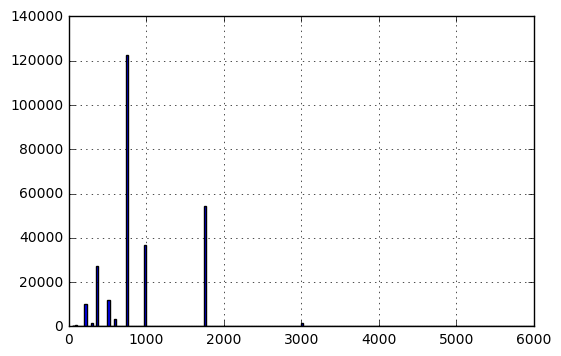

In [5]:
df['Bottle Volume (ml)'].hist(bins = 200)

Most common bottle type is 750ml. 1750ml is second most popular.

In [6]:
# Function to convert money columns from string to float

def conv_money(x):
    x = x.split('.')
    return (float(x[0][1:]) + (float(x[1]) / 100))

In [7]:
# Converting columns with money value to float

df[['State Bottle Cost', 'State Bottle Retail', "Sale (Dollars)"]] = \
df[['State Bottle Cost', 'State Bottle Retail', "Sale (Dollars)"]].applymap(conv_money)

AttributeError: ("'float' object has no attribute 'split'", u'occurred at index State Bottle Cost')

In [ ]:
df['Item Description'] = df['Item Description'].apply(lambda x: x.strip())

In [ ]:
df.info()

## Cleaning Zipcodes

In [ ]:
## Checking to see if all zipcodes have length of 5

df[df['Zip Code'].apply(lambda x: len(x) != 5)]

In [ ]:
# Since all has 5, change all to int types

df[df['Zip Code'].apply(lambda x: int(x))]

In [ ]:
# Even all is length 5, 1 entry was '712-2'
# Googled this, turned out to be area code, change to 51529

df[df['Zip Code'].apply(lambda x: x == '712-2')]

In [ ]:
# Changed erroneous zipcode

df.loc[df['Zip Code'] == '712-2', 'Zip Code'] = '51529'


In [ ]:
# Changed zipcodes to int type

df['Zip Code'] = df['Zip Code'].apply(lambda x: int(x))

## Cleaning City Values

In [ ]:
list(df['City'].unique())

In [ ]:
# There are some 'City' entries which are in lower case while the majority is in Upper Case. 
# To prevent double counting, all "City" entries are changed to upper case

df['City'] = df['City'].apply(lambda x: x.upper())

## Cleaning NaN County entries

In [ ]:
# Create a new dataframe for rows with NaNs in any cells

df_nan = df[pd.isnull(df).any(axis = 1)]

In [ ]:
df_nan.head()

In [ ]:
# Printing columns that contain "NaN" and count the number of NaN entries per column

tbc_list = []

for col in df.columns:
    x = sum(pd.isnull(df[col]))
    if x != 0:
        tbc_list.append(col)
        print col, x

In [ ]:
# Some counties and county numbers are not filled.
# Since "City" column does not contain NaN and Cities are a subset of counties,
# we try to see if there are similar cities with non-empty county values which we can then copy to the NaN county cells


# Create a set of Cities with NaN for county or county Number

city_nan_list = list(df_nan['City'].unique())

city_nan_list

In [ ]:
# Creating a dictionary with "City" as key and collecting all possible corresponding "County" and "County Name"
# as values of the dictionary

nan_cty_dict = {}

for j in city_nan_list:
    c_set = {x for x in df[df['City']==j]['County'] if x > 0} # x > 0 to skip NaN values
    num_set = {x for x in df[df['City']==j]['County Number'] if x > 0}
    nan_cty_dict[j] = [list(c_set), list(num_set)]

nan_cty_dict

In [ ]:
## Replacing NaN county cells using corresponding city value as key

for cty in nan_cty_dict:
    try:
        df.loc[df['City'] == cty, 'County'] = nan_cty_dict[cty][0][0]
        df.loc[df['City'] == cty, "County Number"] = nan_cty_dict[cty][1][0]
    except:
        pass

In [ ]:
# Recreate a new df to check remaining NaN row
df_nan = df[pd.isnull(df[['County','County Number']]).any(axis = 1)]

In [ ]:
# Collect cities with NaN values
city_nan_list = list(df_nan['City'].unique())

city_nan_list

In [ ]:
nan_cty_dict = {}

for j in city_nan_list:
    c_set = {x for x in df[df['City']==j]['County']} # x > 0 to skip NaN values
    num_set = {x for x in df[df['City']==j]['County Number']}
    nan_cty_dict[j] = [list(c_set), list(num_set)]

nan_cty_dict

In [ ]:
# Updating counties by hand

df.loc[df['City'] == 'TABOR', 'County'] = 'Fremont'
df.loc[df['City'] == 'RUNNELLS', 'County'] = 'Polk'
df.loc[df['City'] == 'SEYMOUR', 'County'] = 'Wayne'

In [ ]:
# Recreate a new df to check remaining NaN row
df_nan = df[pd.isnull(df['County'])]

In [ ]:
len(df_nan)

#### Comments:

Remaining 12 rows with empty counties were filled manually. Without a reference of how county numbers were developed, we left the empty county numbers empty. Analyses based on counties will be performed on 'County' instead of 'County Number'.

# ---------------------------------------------------------------

## Cleaning Empty Category Name using Item Decription

In [ ]:
df_nan = df[pd.isnull(df['Category Name'])]
print len(df_nan)
df_nan

In [ ]:
# Create a list of "Item Description" with NaN in rows
item_nan_list = list(df_nan['Item Description'].unique())

item_nan_list

In [ ]:
item_dict = {}

for j in item_nan_list:
    c_set = {x for x in df[df['Item Description']==j]['Category Name'] if x > 0}
    item_dict[j] = list(c_set)

item_dict

In [ ]:
for drink in item_dict:
    try:
        df.loc[df['Item Description'] == drink, 'Category Name'] = item_dict[drink][0]
    except:
        pass

In [ ]:
df_nan = df[pd.isnull(df['Category Name'])]
print len(df_nan)
df_nan

In [ ]:
df_nan['Item Description'].unique()

In [ ]:
package = ['Jack Daniels TN Honey & Jack Daniels TN Fire 750mls w/2Gls', 'Bombay Sapphire w/Glass',\
           'Evan Williams Egg Nog', 'Pinnacle Candy Cane Trial Pack', 'Wild Turkey American Honey Shot Tap',\
           'Knob Creek w/ Crystal Decanter']

for i in package:
    df.loc[df['Item Description'] == i,'Category Name'] = 'DECANTERS & SPECIALTY PACKAGES'

In [ ]:
df.loc[df['Item Description'] == 'Woodford Reserve MC 1838 White Corn',\
       'Category Name'] = 'CORN WHISKIES'

In [ ]:
lique = ['Rothman & Winter Orchard Peach', 'Giffard Creme de Pamplemousse Rose Pink Grapefruit Liqueur',\
        'Pearl Caramel']

for i in lique:
    df.loc[df['Item Description'] == i,'Category Name'] ='MISC. IMPORTED CORDIALS & LIQUEURS'

In [ ]:
df.loc[df['Item Description'] == 'Glenfiddich 1963 Replica HA',\
       'Category Name'] ='SINGLE MALT SCOTCH'

In [ ]:
df.loc[df['Item Description'] == 'Parkers Heritage Collection Malt Whiskey HA',\
       'Category Name'] = "STRAIGHT BOURBON WHISKIES"

In [ ]:
vod = ['High Stick Vodka', 'Ciroc Ten HA']

for i in vod:
    df.loc[df['Item Description'] == i,'Category Name'] = 'IMPORTED VODKA'

df.loc[df['Item Description'] == 'Absolut w/Ginger Beer','Category Name'] = 'VODKA FLAVORED'

#### Comments:

There are still cells in 'Category' with NaN values, however, since we will only be using "Category Name" for analyses, NaNs in 'Category' were not cleaned.

In [ ]:
df.head()

In [ ]:
df.to_csv("Iowa_Liquor_sales_sample_10pct.csv")

## Groupby County

In [ ]:
pd.pivot_table(df, index = ['County', 'Store Number'], values = ['Sale (Dollars)'], \
               aggfunc = [np.mean, max, min, np.sum]).\
                sort_values([('sum', "Sale (Dollars)")], ascending = False).head(10)

In [ ]:
pd.pivot_table(df, index = ['County', 'Store Number'], values = ['Sale (Dollars)'], \
               aggfunc = [np.mean, max, min, np.sum]).\
                sort_values([('mean', "Sale (Dollars)")], ascending = False).head(10)

## Groupby Zipcode

In [ ]:
pd.pivot_table(df, index = ['Zip Code', 'Store Number'], values = ['Sale (Dollars)'], \
               aggfunc = [np.mean, max, min, np.sum]).\
                sort_values([('sum', 'Sale (Dollars)')], ascending = False).head(10)

In [ ]:
pd.pivot_table(df, index = ['Zip Code'], values = ['Sale (Dollars)'], \
               aggfunc = [np.mean, max, min, np.sum]).\
                sort_values([('mean', 'Sale (Dollars)')], ascending = False).head(10)

## Groupby City

In [ ]:
pd.pivot_table(df, index = ['City', 'Store Number'], values = ['Sale (Dollars)'],\
               aggfunc = [np.mean, np.sum, np.std]).sort_values([('mean', 'Sale (Dollars)')], \
                                                                ascending = False).head(10)

In [ ]:
pd.pivot_table(df, index = ['City', 'Store Number'], values = ['Sale (Dollars)'],\
               aggfunc = [np.mean, np.sum, np.std]).sort_values([('sum', 'Sale (Dollars)')], \
                                                                ascending = False).head(10)

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [ ]:
from sklearn import linear_model


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.